---

### Комментарий наставника

Привет, Роман!

Спасибо за проделанную работу. Все комментарии увидишь по ходу работы.

---

# Отток клиентов

#### Друзык Роман Богданович

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

***
***

# 1. Подготовка данных

*По условию задания, нам необходимо предсказывать, останется ли человек клиентом банка. Это задача классификации*

In [55]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle

*Загрузим необходимые библиотеки и исходный набор данных, ознакомимся с ним*

In [56]:
data = pd.read_csv('/datasets/Churn.csv')

*Посмотрим на размер данных*

In [57]:
data.shape

(10000, 14)

*Размер нашей выборки 10000 событий и 14 признаков*

In [58]:
data.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

*Описание признаков*
 * RowNumber — индекс строки в данных
 * CustomerId — уникальный идентификатор клиента
 * Surname — фамилия
 * CreditScore — кредитный рейтинг
 * Geography — страна проживания
 * Gender — пол
 * Age — возраст
 * Tenure — количество недвижимости у клиента
 * Balance — баланс на счёте
 * NumOfProducts — количество продуктов банка, используемых клиентом
 * HasCrCard — наличие кредитной карты
 * IsActiveMember — активность клиента
 * EstimatedSalary — предполагаемая зарплата

*Посмотрим на различные характеристики числовых признаков*

In [59]:
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

*Типы данных указаны верно, каких то замечаний нет*

In [60]:
data.describe()

RowNumber    CustomerId   CreditScore           Age       Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  9091.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800     4.997690   
std     2886.89568  7.193619e+04     96.653299     10.487806     2.894723   
min        1.00000  1.556570e+07    350.000000     18.000000     0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000     2.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000     5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000     7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000    10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000       1.000000      0.00000        0.000000   
25%         0.000000       1.000000      0.00000        0.000000   
50%     97198.540000       1.000000      1.00000        1.000000   
75%    127644.240000       2.000000      1.00000        1.000000   
max    250898.090000       4.000000      1.00000        1.000000   

       EstimatedSalary        Exited  
count     10000.000000  10000.000000  
mean     100090.239881      0.203700  
std       57510.492818      0.402769  
min          11.580000      0.000000  
25%       51002.110000      0.000000  
50%      100193.915000      0.000000  
75%      149388.247500      0.000000  
max      199992.480000      1.000000

*На первый взгляд бросается то, что у 25% клиентов нулевой баланс, а так же признак активности клиента так же нулевой у 25%, возможно, эта информация будет важна в дальнейшем.*

***

*Посмотрим на количество пропусков в данных*

In [61]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

*Видим, что пропуски есть только в данных околичестве недвижимости у клиента. Предположительно, что отсутствие данных в данном пункте говорит нам о том, что у клиента нет недвижимости. Разберем данный пункт подробнее*

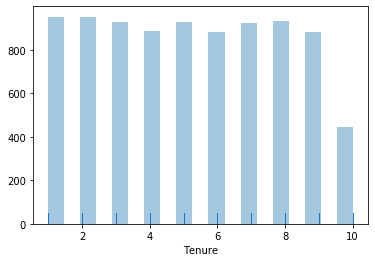

In [62]:
sns.distplot(data.query('Tenure>0').Tenure, kde=False, rug=True);

*Видим, что у каждого значения в признаке Tenure примерно 900-1000 событий, что примерно равно количеству пропусков. Не отвергаем изначальное предположение, что пропуски - это нули.*

In [63]:
data = data.fillna(0)

---

### Комментарий наставника

Согласен. Обоснованно заполнил нулями, хотя здесь и медиана не навредила бы :)

---

***

*Для дальнейшего анализа выкинем признаки, которые нам не нужны, а именно: RowNumber, CustomerId, Surname.*

In [64]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

*Построим гистограммы для 4 величин, распределения которых интерсно было бы оценить. А именно: CreditScore, Age, Balance, EstimatedSalary*

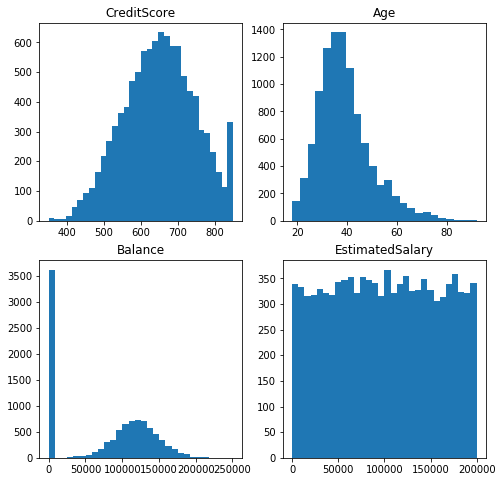

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0, 0].hist(data['CreditScore'], bins=32)
axes[0, 0].set_title("CreditScore")
axes[0, 1].hist(data['Age'], bins=24)
axes[0, 1].set_title("Age")
axes[1, 0].hist(data['Balance'], bins=30)
axes[1, 0].set_title("Balance")
axes[1, 1].hist(data['EstimatedSalary'], bins=30)
axes[1, 1].set_title("EstimatedSalary");

*Видим, что кредитный рейтин, возраст и баланс имеют распределения, похожие на нормальные. Предполагаемая зарплата имеет равномерное распредление, что очень удивительно для жителя РФ(это свидетельствует о довольно равномерном расслоении клиентов по уровню доходов). Имеется выброс в 0 у признака Баланс, никак его обрабатывать не будем, возможно для нашей будущей модели это может быть важным признаком для принятия решения останется ли клиент в банке или перестанет быть его клиентом.*

---

### Комментарий наставника

Добавить нечего. Здорово! 

Нормализовать бы эти "горочки" :) 

---

***

*Посмотрим, жителями каких стран являются клиенты банка*

In [66]:
data.Geography.value_counts(normalize=True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

*Всего три страны, не так много, чтобы список разросся при дамми-кодировании*

***

*В наших данных имеется два категориального признака: Geography, Gender. Проведем дамми-кодирования данных признаков.*

In [67]:
data = pd.get_dummies(data, drop_first=True)

In [68]:
data

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0             619   42     2.0       0.00              1          1   
1             608   41     1.0   83807.86              1          0   
2             502   42     8.0  159660.80              3          1   
3             699   39     1.0       0.00              2          0   
4             850   43     2.0  125510.82              1          1   
...           ...  ...     ...        ...            ...        ...   
9995          771   39     5.0       0.00              2          1   
9996          516   35    10.0   57369.61              1          1   
9997          709   36     7.0       0.00              1          0   
9998          772   42     3.0   75075.31              2          1   
9999          792   28     0.0  130142.79              1          1   

      IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0                  1        101348.88       1                  0   
1                  1        112542.58       0                  0   
2                  0        113931.57       1                  0   
3                  0         93826.63       0                  0   
4                  1         79084.10       0                  0   
...              ...              ...     ...                ...   
9995               0         96270.64       0                  0   
9996               1        101699.77       0                  0   
9997               1         42085.58       1                  0   
9998               0         92888.52       1                  1   
9999               0         38190.78       0                  0   

      Geography_Spain  Gender_Male  
0                   0            0  
1                   1            0  
2                   0            0  
3                   0            0  
4                   1            0  
...               ...          ...  
9995                0            1  
9996                0            1  
9997                0            0  
9998                0            1  
9999                0            0  

[10000 rows x 12 columns]

***

*Произведем нормирование признаков, чтобы они были у нас в одной размерности, для более адекватного поведения моделей*

*Нормировать будем следующие признаки:*
 - CreditScore
 - Age
 - Tenure
 - Balance
 - NumOfProducts
 - EstimatedSalary

In [69]:
from sklearn.preprocessing import MinMaxScaler
normalized_ax = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = MinMaxScaler()
scaler.fit(data[normalized_ax])
data.loc[:, normalized_ax] = scaler.transform(data[normalized_ax])

---

### Комментарий наставника

Да, такое преобразование точно нельзя упускать. Молодец

---

*Посмотрим на финальный набор данных*

In [70]:
data.head()

CreditScore       Age  Tenure   Balance  NumOfProducts  HasCrCard  \
0        0.538  0.324324     0.2  0.000000       0.000000          1   
1        0.516  0.310811     0.1  0.334031       0.000000          0   
2        0.304  0.324324     0.8  0.636357       0.666667          1   
3        0.698  0.283784     0.1  0.000000       0.333333          0   
4        1.000  0.337838     0.2  0.500246       0.000000          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0               1         0.506735       1                  0   
1               1         0.562709       0                  0   
2               0         0.569654       1                  0   
3               0         0.469120       0                  0   
4               1         0.395400       0                  0   

   Geography_Spain  Gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0            0  
4                1            0

### Вывод

Ознакомившись с нашим набором данных, мы провели следующую предобработку:
 * Заполнили 0 признак наличия недвижимости у клиента
 * Удалили столбцы, которые не будут полезны при обучении модели
 * Провели дамми-кодирование двух категориальных прихнаков
 * Провели нормирование наших признаков в интервале от 0 до 1

***
***

# 2. Исследование задачи

*Оценим баланс классов, которые нам необходимо предсказывать в нашей изначальной выборке*

In [17]:
data.Exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

*Мы видим, что у нас ярко-выраженный дисбаланс классов, в пропорции 80/20*

***

*Обучим простейшую модель классификации K-ближайших соседей, на не сбалансированном датасете и сравним предсказание данной модели со случайной моделью*

*Для этого подготовим наши данные, разобъем всю выборку на три части: обучающую, валидационную и тестовую.*

In [75]:
data = data.query('Balance>0')
X = data.drop('Exited', axis=1)
indx = X.index
y = data['Exited']

In [76]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=.3)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, random_state=42, test_size=.5)

In [77]:
from sklearn.neighbors import KNeighborsClassifier

In [78]:
for n_neighbors in range(1, 10):
    knc = KNeighborsClassifier(n_neighbors=n_neighbors)
    predicted = knc.fit(X_train, y_train).predict(X_valid)
    probabilities_valid = knc.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    print(f'n: {n_neighbors}\tAccuracy: {round(knc.score(X_train, y_train), 3)}\
    \tF1: {round(f1_score(y_valid.values, predicted),3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

n: 1	Accuracy: 1.0    	F1: 0.429    	ROC AUC: 0.623
n: 2	Accuracy: 0.862    	F1: 0.284    	ROC AUC: 0.669
n: 3	Accuracy: 0.871    	F1: 0.434    	ROC AUC: 0.694
n: 4	Accuracy: 0.831    	F1: 0.332    	ROC AUC: 0.709
n: 5	Accuracy: 0.84    	F1: 0.4    	ROC AUC: 0.704
n: 6	Accuracy: 0.818    	F1: 0.32    	ROC AUC: 0.71
n: 7	Accuracy: 0.822    	F1: 0.401    	ROC AUC: 0.713
n: 8	Accuracy: 0.813    	F1: 0.295    	ROC AUC: 0.713
n: 9	Accuracy: 0.816    	F1: 0.339    	ROC AUC: 0.716


*Будем ориентироваться на F1-меру, максимальное значение данная метрика имеет при количестве соседей равным 5.*

*Проверим нашу модель на адекватность, сгенерируем псевдослучайную последовательность 0 и 1, равную размером с тестовой выборкой и сравним метрики*

In [80]:
y_random = [np.random.randint(0, 2) for i in range(len(y_test))]

*Обучим нашу модель с гиперпареметром количчества соседей - 5*

In [81]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
probabilities_valid = model.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1 на тестовой выборке: {:.3f}".format(f1_score(y_test, predicted)))
print("F1 на случайной выборке: {:.3f}".format(f1_score(y_random, predicted)))

print("ROC AUC на тестовой выборке: {:.3f}".format(roc_auc_score(y_test, probabilities_one_valid)))
print("ROC AUC на случайной выборке: {:.3f}".format(roc_auc_score(y_random, probabilities_one_valid)))


F1 на тестовой выборке: 0.439
F1 на случайной выборке: 0.207
ROC AUC на тестовой выборке: 0.726
ROC AUC на случайной выборке: 0.523


*Построим ROC-кривую*

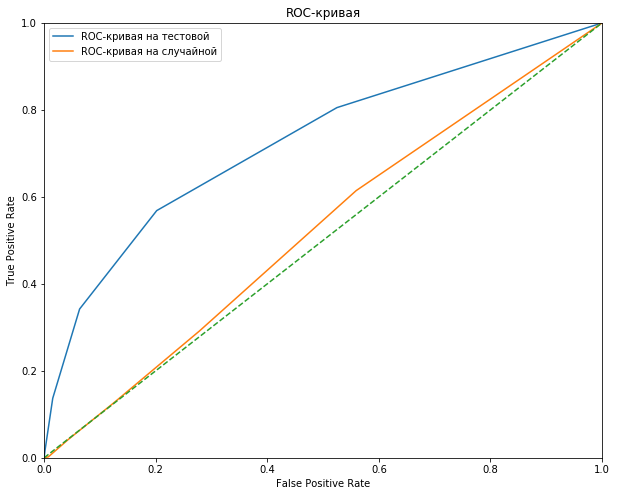

In [82]:
fpr_test, tpr_test, thresholds = roc_curve(y_test, probabilities_one_valid)
fpr_random, tpr_random, thresholds = roc_curve(y_random, probabilities_one_valid)
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, label='ROC-кривая на тестовой')
plt.plot(fpr_random, tpr_random, label='ROC-кривая на случайной')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Вывод

*Мы провели построение модели класификации методом ближайших соседей на несбланасированом наборе данных и выяснили, что наша модель предсказывает лучше чем случайная модель, но недостаточно хорошо, чтобы данную модель можно было использовать. Есть потенциал роста предсказательной способности. А именно мы можем сбалансировать классы и подобрать более оптимальную модель классификации*

***
***

---

### Комментарий наставника

Интересная мысль

---

# 3. Борьба с дисбалансом

*Ранее мы определили пропорцию дисбалана классов и выяснили, что она примерно равна 80/20.*

*Исключительно сокращать 0 класс или исключительно увеличивать 1 класс не предстваляется наиболее оптимальным решением, так как при первом варианте мы слишком сократим размер набора данных, а при втором варианте избыточно "раздуем" его*

*Остановимся на промежуточном варианте, а именно:*
 * *Сократим 0 класс на 23%, до 6000 событий*
 * *Увеличим 1 класс в 3 раза, до 6000 событий*

*Выделим сразу отдельно обучающую выборку, валидационную и тестовую. Балансировать классы будем только на тестовой выборке, а валидационную и тестовую оставим в исходном состоянии*

In [83]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=.3)

***

*Напишем функцию, которая уменьшит размер выборки, сокращая класс 0*

In [84]:
def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=42)] + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=42)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(X_downsampled, y_downsampled, random_state=12345)
    
    return X_downsampled, y_downsampled

In [85]:
X_downsampled, y_downsampled = downsample(X_train, y_train, 0.77)

*Теперь напишем функцию, которая увеличит размер нашей выборки, увеличивая класс 1*

In [86]:
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=42)
    
    return X_upsampled, y_upsampled

In [87]:
X_upsampled, y_upsampled = upsample(X_downsampled, y_downsampled, 3)

*Мы получили сбалансированный набор данных с пропорцией 50/50*

In [88]:
y_upsampled.value_counts(normalize=True)

1    0.550996
0    0.449004
Name: Exited, dtype: float64

***

*Теперь подготовим данный набор данных для подбора оптимальной модели классификации*

*Разобъем существующий набор данных на три составляющие:*
 * *Обучающий набор - 70%*
 * *Валидационный набор - 15%*
 * *Тестовый набор - 15%*

In [89]:
X_train = X_upsampled
y_train = y_upsampled
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, random_state=42, test_size=.5)
print("Размер обучающей выборки: {}".format(X_train.shape))
print("Размер валидационной выборки: {}".format(X_valid.shape))
print("Размер тестовой выборки: {}".format(X_test.shape))

Размер обучающей выборки: (5069, 11)
Размер валидационной выборки: (833, 11)
Размер тестовой выборки: (834, 11)


In [90]:
y_train.value_counts(normalize=True)

1    0.550996
0    0.449004
Name: Exited, dtype: float64

---

### Комментарий наставника

На самом деле, эту процедуру лучше производить ПОСЛЕ разделения датасета и только на обучаемой части, чтобы иметь более достоверные данные о качестве модели

---

***

### Приступим к подбору оптимальной модели классификации

#### K-ближайших соседей

In [91]:
from sklearn.neighbors import KNeighborsClassifier

In [92]:
%%time
for n_neighbors in range(1, 9):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    predicted = model.fit(X_train, y_train).predict(X_valid)
    probabilities_one_valid = model.predict_proba(X_valid)[:, 1]
    
    print(f'K: {n_neighbors}\tF1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

K: 1	F1-мера на валидации: 0.443    	ROC AUC: 0.629
K: 2	F1-мера на валидации: 0.443    	ROC AUC: 0.658
K: 3	F1-мера на валидации: 0.475    	ROC AUC: 0.673
K: 4	F1-мера на валидации: 0.475    	ROC AUC: 0.684
K: 5	F1-мера на валидации: 0.475    	ROC AUC: 0.694
K: 6	F1-мера на валидации: 0.489    	ROC AUC: 0.702
K: 7	F1-мера на валидации: 0.489    	ROC AUC: 0.702
K: 8	F1-мера на валидации: 0.489    	ROC AUC: 0.702
CPU times: user 1.07 s, sys: 24 ms, total: 1.09 s
Wall time: 1.17 s


*Самый высокий параметр F1-меры при К=3.*

***

#### Логистическая регрессия

In [35]:
from sklearn.linear_model import LogisticRegression

In [93]:
%%time
model = LogisticRegression(solver='liblinear')

predicted = model.fit(X_train, y_train).predict(X_valid)
probabilities_one_valid = model.predict_proba(X_valid)[:, 1]
    
print(f'F1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

F1-мера на валидации: 0.52    	ROC AUC: 0.755
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 37.2 ms


*Данные хуже, чем у к-соседей, но тоже превышаем минимально-допустимый порог*

***

#### Классификатор линейных векторов

In [37]:
from sklearn.svm import LinearSVC

In [94]:
%%time
model = LinearSVC(random_state=42)

predicted = model.fit(X_train, y_train).predict(X_valid)
probabilities_one_valid = model.decision_function(X_valid) > 0
   
print(f'F1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

F1-мера на валидации: 0.527    	ROC AUC: 0.691
CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 189 ms


*Модель предсказывает на уровне логистической регрессии, но порог в 0.59 снова превышен. Так же надо обратить внимание, что у данной модели нет predict_proba, для оценки ROC AUC используем decision_function*

***

#### Метод опорных векторов

In [39]:
from sklearn.svm import SVC

In [95]:
%%time
model = SVC(C=10, gamma=3, random_state=42, probability=True)

predicted = model.fit(X_train, y_train).predict(X_valid)
probabilities_one_valid = model.predict_proba(X_valid)[:, 1]
    
print(f'F1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

F1-мера на валидации: 0.502    	ROC AUC: 0.723
CPU times: user 6.93 s, sys: 84 ms, total: 7.01 s
Wall time: 7.08 s


*Данный метод показывает очень хороший уровень F1 и ROC AUC, но уровень gamma=50 - довольно высокая степень близости точек. Если бы можно еще использовать полиномы признаков, то, возможно, метрики можно было бы подтянуть еще*

***

#### Дерево решений

In [41]:
from sklearn.tree import DecisionTreeClassifier

*Проверим, как глубина дерева влияет на его предсказывающую способность*

In [96]:
%%time
for max_depth in range(10, 30, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    predicted = model.fit(X_train, y_train).predict(X_valid)
    probabilities_one_valid = model.predict_proba(X_valid)[:, 1]
    
    print(f'Глубина: {max_depth}\tF1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

Глубина: 10	F1-мера на валидации: 0.535    	ROC AUC: 0.708
Глубина: 12	F1-мера на валидации: 0.525    	ROC AUC: 0.692
Глубина: 14	F1-мера на валидации: 0.495    	ROC AUC: 0.664
Глубина: 16	F1-мера на валидации: 0.495    	ROC AUC: 0.663
Глубина: 18	F1-мера на валидации: 0.47    	ROC AUC: 0.641
Глубина: 20	F1-мера на валидации: 0.476    	ROC AUC: 0.652
Глубина: 22	F1-мера на валидации: 0.51    	ROC AUC: 0.673
Глубина: 24	F1-мера на валидации: 0.505    	ROC AUC: 0.669
Глубина: 26	F1-мера на валидации: 0.505    	ROC AUC: 0.669
Глубина: 28	F1-мера на валидации: 0.505    	ROC AUC: 0.669
CPU times: user 336 ms, sys: 0 ns, total: 336 ms
Wall time: 385 ms


Дерево показывает максимум при глубине 20.

***

#### Случайный лес деревьев решений

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
%%time
for n_estimators in range(10, 200, 20):
    
    model = RandomForestClassifier(n_estimators=n_estimators, 
                                 max_depth=9, 
                                 random_state=42)
    
    predicted = model.fit(X_train, y_train).predict(X_valid)
    probabilities_one_valid = model.predict_proba(X_valid)[:, 1]
    
    print(f'Деревьев: {n_estimators}\tF1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

Деревьев: 10	F1-мера на валидации: 0.561    	ROC AUC: 0.788
Деревьев: 30	F1-мера на валидации: 0.583    	ROC AUC: 0.797
Деревьев: 50	F1-мера на валидации: 0.577    	ROC AUC: 0.796
Деревьев: 70	F1-мера на валидации: 0.581    	ROC AUC: 0.795
Деревьев: 90	F1-мера на валидации: 0.587    	ROC AUC: 0.797
Деревьев: 110	F1-мера на валидации: 0.582    	ROC AUC: 0.798
Деревьев: 130	F1-мера на валидации: 0.581    	ROC AUC: 0.797
Деревьев: 150	F1-мера на валидации: 0.579    	ROC AUC: 0.797
Деревьев: 170	F1-мера на валидации: 0.586    	ROC AUC: 0.799
Деревьев: 190	F1-мера на валидации: 0.584    	ROC AUC: 0.798
CPU times: user 6.69 s, sys: 20 ms, total: 6.71 s
Wall time: 6.76 s


*Максимальное значение метрики мы получили при 130 деревьях, соизмеримые с методом опорных векторов*

***

---

### Комментарий наставника

Хочу добавить, что для случайного леса стоит перебирать не только количество деревьев, но и глубину дерева. Это позволило бы получить результаты более точные.

Учитывая специфику случайного леса, выбранная ранее глубина с наибольшей вероятностью не будет САМОЙ оптимальной, как с обычным деревом.

---


#### Градиентный бустинг деревьев решений

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
%%time
for n_estimators in range(10, 150, 20):
    
    model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=9, random_state=42, learning_rate=.25)
    
    predicted = model.fit(X_train, y_train).predict(X_valid)
    probabilities_one_valid = model.predict_proba(X_valid)[:, 1]
    
    print(f'Деревьев: {n_estimators}\tF1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

Деревьев: 10	F1-мера на валидации: 0.596    	ROC AUC: 0.777
Деревьев: 30	F1-мера на валидации: 0.567    	ROC AUC: 0.783
Деревьев: 50	F1-мера на валидации: 0.553    	ROC AUC: 0.778
Деревьев: 70	F1-мера на валидации: 0.525    	ROC AUC: 0.78


При количестве деревьев - 70, глубине каждого дерева - 12 (примерное количество признаков), а так же коефициенте обучения - 0.25, мы получаем наилучший результат из всех рассмотренных.

***

### Вывод

*Мы рассмотрели некоторое количество классификаторов для нашего набора данных, по анализу результатов, сделаем опреденные выводы:*
 * K-ближайших соседей хорошо предсказывает при минимальном К=1, а так же обладает очень быстрым временем работы
 * Логистическая регрессия показала себя не самым лучшим образом, возможно, если бы мы взяли полиномы признаков, то метрики можно было бы улучшить
 * Классификатор линейных векторов показал предсказательную силу на уровне логистической регрессии, аналогично, при использовании полиномов признаков метрики можно было бы поднять. Это было бы равнозначно "ядерному трюку"
 * Метод опорных векторов проявил себя на данном наборе данных очень хорошо, но имеет очень высокое время обучения
 * Дерево решений, на данном наборе, так же проявило себя довольно хорошо, но недостаточно, чтобы мы его использовали как основной метод классификации
 * Случайный лес деревьев решений так же показал хорошую предсказательную способность, соизмеримую с методом опорных векторов, но время обучения модели гораздо выше
 * Градиентный бустинг деревьев решений показал наивысший результат при относительно небольшом количестве деревьев.

**Именно метод градиентного бустинга мы и будем использовать для предсказания на тестовом наборе**

---

### Комментарий наставника

Здорово! Ты перебрал немало моделей с различными параметрами, и смог определить действительно качественное решение.

---

***
***

# 4. Тестирование модели

*Мы определили самый продуктивный классификатор, протестируем его теперь на тестовом наборе данных*

*Обучим модель еще раз, с гиперпараметрами, которые мы определили, как наиболее удачные*

In [47]:
model = RandomForestClassifier(n_estimators=110, 
                                 max_depth=9, 
                                 random_state=42)
    
model.fit(X_train, y_train)
predict_valid = model.predict(X_valid)
probabilities_one_valid = model.predict_proba(X_valid)[:, 1]
    
print(f'F1-мера на валидации: {round(f1_score(y_valid, predict_valid), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

F1-мера на валидации: 0.62    	ROC AUC: 0.859


*Теперь протестируем модель на тестовых данных*

In [48]:
predict_test = model.predict(X_test)
probabilities_one_valid = model.predict_proba(X_test)[:, 1]
    
print(f'F1-мера на тесте: {round(f1_score(y_test, predict_test), 3)}\
    \tROC AUC: {round(roc_auc_score(y_test, probabilities_one_valid), 3)}')

F1-мера на тесте: 0.62    	ROC AUC: 0.874


*На тестовом наборе наша модель показывает очень хорошие результаты, соизмеримые с результатами на валидационном наборе*

***

*Проверим баланс предсказываемых классов*

In [49]:
pd.Series(predict_test).value_counts(normalize=True)

0    0.745983
1    0.254017
dtype: float64

*Баланс классов соблюден с перекосом в 4% в сторону предсказания вероятности ухода клиента. Можем считать нашу модель адекватной, с отличной предсказательной способностью.*

***

#### Исследуем ROC-кривую нашей модели

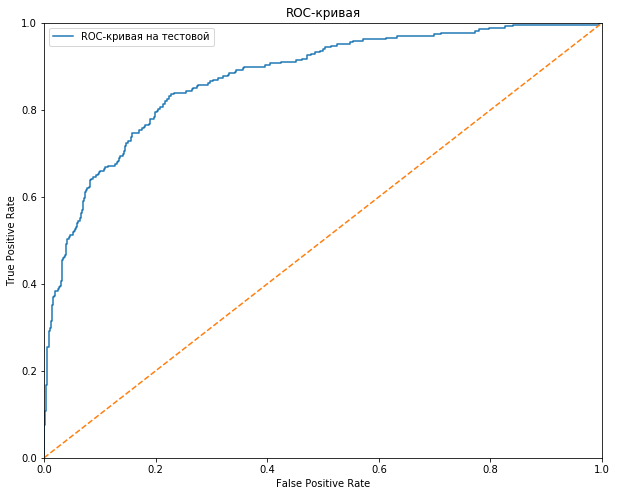

In [50]:
fpr_test, tpr_test, thresholds = roc_curve(y_test, probabilities_one_valid)
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, label='ROC-кривая на тестовой')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Вывод

*По данному графику мы видим, что наша модель очень хорошо предсказывает TPR при практически нулевом FPR. Данное обстоятельство может нам сигнализировать, что модель перобучилась на наборе данных, так как в нем присутствовало большое количество повторений событий. Вероятно в тестовый набор попали события, которые были и в обучающем наборе, либо модель действительно хорошо вытянула из набора данных общие закономерности и будет хорошо предсказывать и на неизвестном ей наборе данных*

*Для более адекватной оценки модели, хорошо было бы иметь отдельный тестовый набор данных.*

***
***

### Общий вывод

*В данном проекте мы реализовали модель классификации, для сохранения клиентов банка, вероятность точного предсказания данной модели - почти 60%, что можно считать довольно хорошим показателем.*

*Службе маркетинга можно было бы рекомендовать взять данную модель для пронозирования оттока на тестирование на реальных данных*

*При наличии истории по тому, как политика удержания влияла на клиента, можно было бы рекомендовать модернизацию данной модели, чтобы она учитывала uplift-метрику*

---

### Комментарий наставника

Поздравляю со сдачей работы!

Мне понравились твои решения. Ты перебрал достаточно высокий зоопарк моделей, и смог оценить качество.
Также обращаю внимание, что производить балансировку классов стоит ТОЛЬКО на обучаемой выборке, во избежания переобучения.

Остальное я написал в комментариях. Желаю успеха в обучении.

---

***
***

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*